In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

In [3]:
from src.d02_intermediate.classifier_data_api import ClassifierDataApi
from src.d04_modeling import propositional_classifier as pc
from src.d04_modeling.naive_classifier import NaiveClassifier

We load the data with an arbitrary classifier, and get an instance of the ClassifierDataApi class to access the data:

In [4]:
load_data = pc.andClassifier([])
cda = ClassifierDataApi()

Loading Block FRL data...Adding African-American counts to FRL data...
0.9854
Loading Block Demographic data...0.1914
Loading Student Demographic data...4.2287


# Eligibility Criteria:

This work is an extension of the Neighborhood Proxy Criteria. We would like to replace that for a more general eligibitliy criteria that takes into account:

1. Public housing projects in a block (data provided by the School District, SFHA_ex_Sr column)
2. Red-lining historical maps

Blocks satisfying at least one of these criteria are eligible to receive the equity tiebreaker.

We also address transparency issues. The eligibility criteria never automatically give a block the equity tiebreaker, so that knowing these criteria is not enough for a family to "game" the system by moving. After blocks are pre-selected by these criteria, the demographic composition of the block should be taken into account to actually decide upon the tiebreaker.

More criteria can be incorporated, and we suggest that criteria which measure the development status and number of resources in a neighborhood are incorporated here. For example, accessibility and public transportation or gentrification. Importantly, the eligibility criteria can be provided at a coarser level than the blocks, so that more datasets are potentially available.

## 1. San Francisco Public Housing

The first criteria qualifying a block for the equity tiebreaker is whether there are non-senior public housing developments in that block. We can visualize these blocks in the map below:

In [ ]:
housing_gdf = cda.get_map_df_data("Housing")

fig, ax = plt.subplots(figsize=(20,20))
ax = housing_gdf.plot(column="Housing", ax=ax)
ax.set_title("Blocks with non-Senior SF Housing", fontsize=50)
plt.show()

This a very limited number of blocks (65). Other proxies for affordable housing could be considered, such as the SA Housing rathern than SFHA Housing. If we award a tiebreaker to everyone with public housing:

In [ ]:
c = pc.andClassifier(["Housing"], binary_var=[0])

print("{:.1%} of all the students receive the tiebreaker\n".format(c.pr([])))

print("{:.1%} of all the focal students receive a tiebreaker".format(c.tpr([])))
print("{:.1%} of all the non-focal students receive a tiebreaker".format(c.fpr([])))
print("{:.1%} of the students receiving a tiebreaker are non-focal".format(1-c.precision([])))

## 2. Red-Lining History

Another dataset we would like to incorporate is historical red-lining maps. This data is available publicaly and is immutable: https://dsl.richmond.edu/panorama/redlining/#loc=12/37.83/-122.464&city=san-francisco-ca&area=null&text=downloads

In [ ]:
import geopandas as gpd

sf_gdf = cda.get_map_df_data("Housing")

redlining_gdf_raw = gpd.read_file("/share/data/school_choice_equity/data/CASanFrancisco1937.geojson")
redlining_gdf = redlining_gdf_raw.dissolve(by='holc_grade').to_crs(sf_gdf.crs)

fig, ax = plt.subplots(figsize=(20,20))
color_mapping = {"A": "green", "B": "blue", "C":"yellow", "D":"red"}
ax = housing_gdf.plot(color='gray', ax=ax, alpha=0.9)
redlining_gdf.plot(ax=ax, categorical=True,
                   color=redlining_gdf.index.map(color_mapping), alpha=0.6,
                   legend=True, legend_kwds={"fontsize":30})

Eligible blocks will then be those in the HOLC grade D as per above, in addition to blocks with SFHA housing projects:

In [ ]:
sf_gdf['Redline'] = sf_gdf['geometry'].buffer(0).intersects(redlining_gdf['geometry']['D'].buffer(0), align=False)
sf_gdf['Eligible'] = sf_gdf.eval("Housing or Redline")

fig, ax = plt.subplots(figsize=(20,20))
ax = sf_gdf.plot(ax=ax, column='Eligible')
ax.set_title("Eligible Blocks", fontsize=50)

The redline column is automatically retrived in the classifier data api as part of the block dataframe. Therefore it can be used in tiebreakers.

In [ ]:
eligibility_classifier = pc.orClassifier(["Housing", "Redline"], binary_var=[0,1])

Now we can use this elgibility criteria (which is fixed, thus needs no parameters) and use it on a classifier. For example, simple ordering based on the percentage of intersection students:

In [ ]:
c = pc.andClassifier(["pctBoth"], positive_group="nBoth", eligibility_classifier=eligibility_classifier)

In [ ]:
params = [0, 0.20, 0.40, 0.5]
fig, Axes = plt.subplots(figsize=(40,40), nrows=2, ncols=2)
pr, fpr, fnr, imp = [], [], [], []

for beta, ax in zip(params, Axes.flatten()):
    map_df = c.get_tiebreaker_map(beta, "tiebreaker")
    ax = map_df.plot(column="tiebreaker", ax=ax, cmap="viridis",
                     legend=False, missing_kwds={'color': 'lightgrey'})
    ax.set_title("Intersection " + "$(\%) \geq $"+str(100*beta)+"%", fontsize=40)
    plt.axis('off')
    pr.append(c.pr(beta))
    fpr.append(c.fpr(beta))
    fnr.append(c.fnr(beta))
    imp.append(1 - c.precision(beta))

fpr = 100*np.reshape(np.array(fpr), (2,2)).round(decimals=2)
fnr = 100*np.reshape(np.array(fnr), (2,2)).round(decimals=2)
pr = 100*np.reshape(np.array(pr), (2,2)).round(decimals=2)
imp = 100*np.reshape(np.array(imp), (2,2)).round(decimals=2)
        
fig.tight_layout()
plt.show()

In [ ]:
pr, fpr, fnr, imp

## 3. Neighborhood Criteria:

Note that the eligibility classifier can also replace the old neighborhood criteria:

In [ ]:
nbhd_eligibility_classifier = pc.orClassifier(["BG_pctFocal"], group_criterion="nbhd")
c2 = pc.andClassifier(["pctBoth"], positive_group="nBoth", eligibility_classifier=nbhd_eligibility_classifier, eligibility_params=[0.5], frl_key='kt5')
params = 0.35

fig, ax = plt.subplots(figsize=(20,20))
ax = c2.plot_map(params=params, ax=ax)

## 4. Some Results:

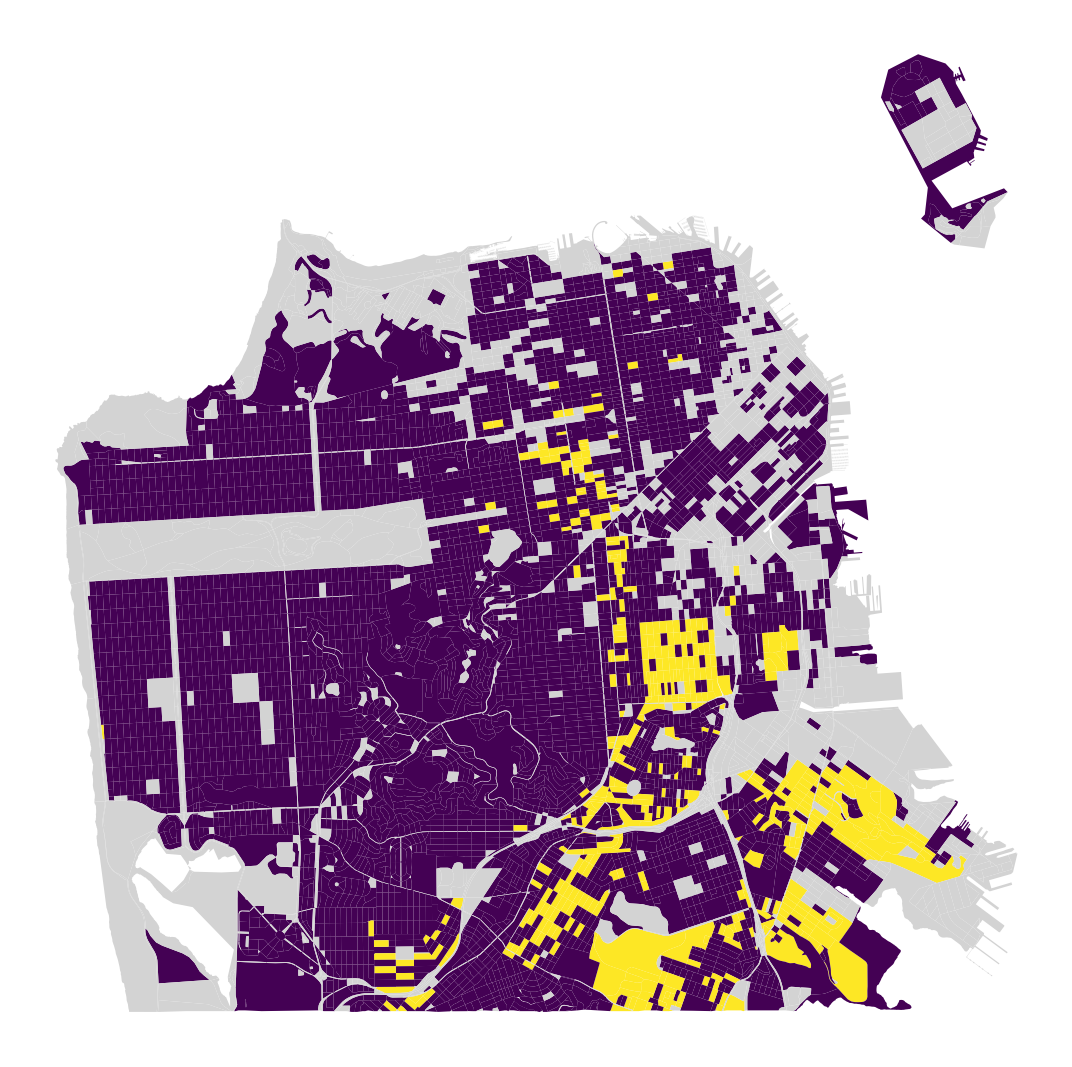

In [6]:
eligibility_classifier = pc.orClassifier(["Housing", "Redline"], binary_var=[0,1])
c = pc.andClassifier(["pctBoth"], positive_group="nBoth", eligibility_classifier=eligibility_classifier, frl_key='kt5')
params = 0.35

fig, ax = plt.subplots(figsize=(15,15))
ax = c.plot_map(params=params, ax=ax)

Considering AAFRL:

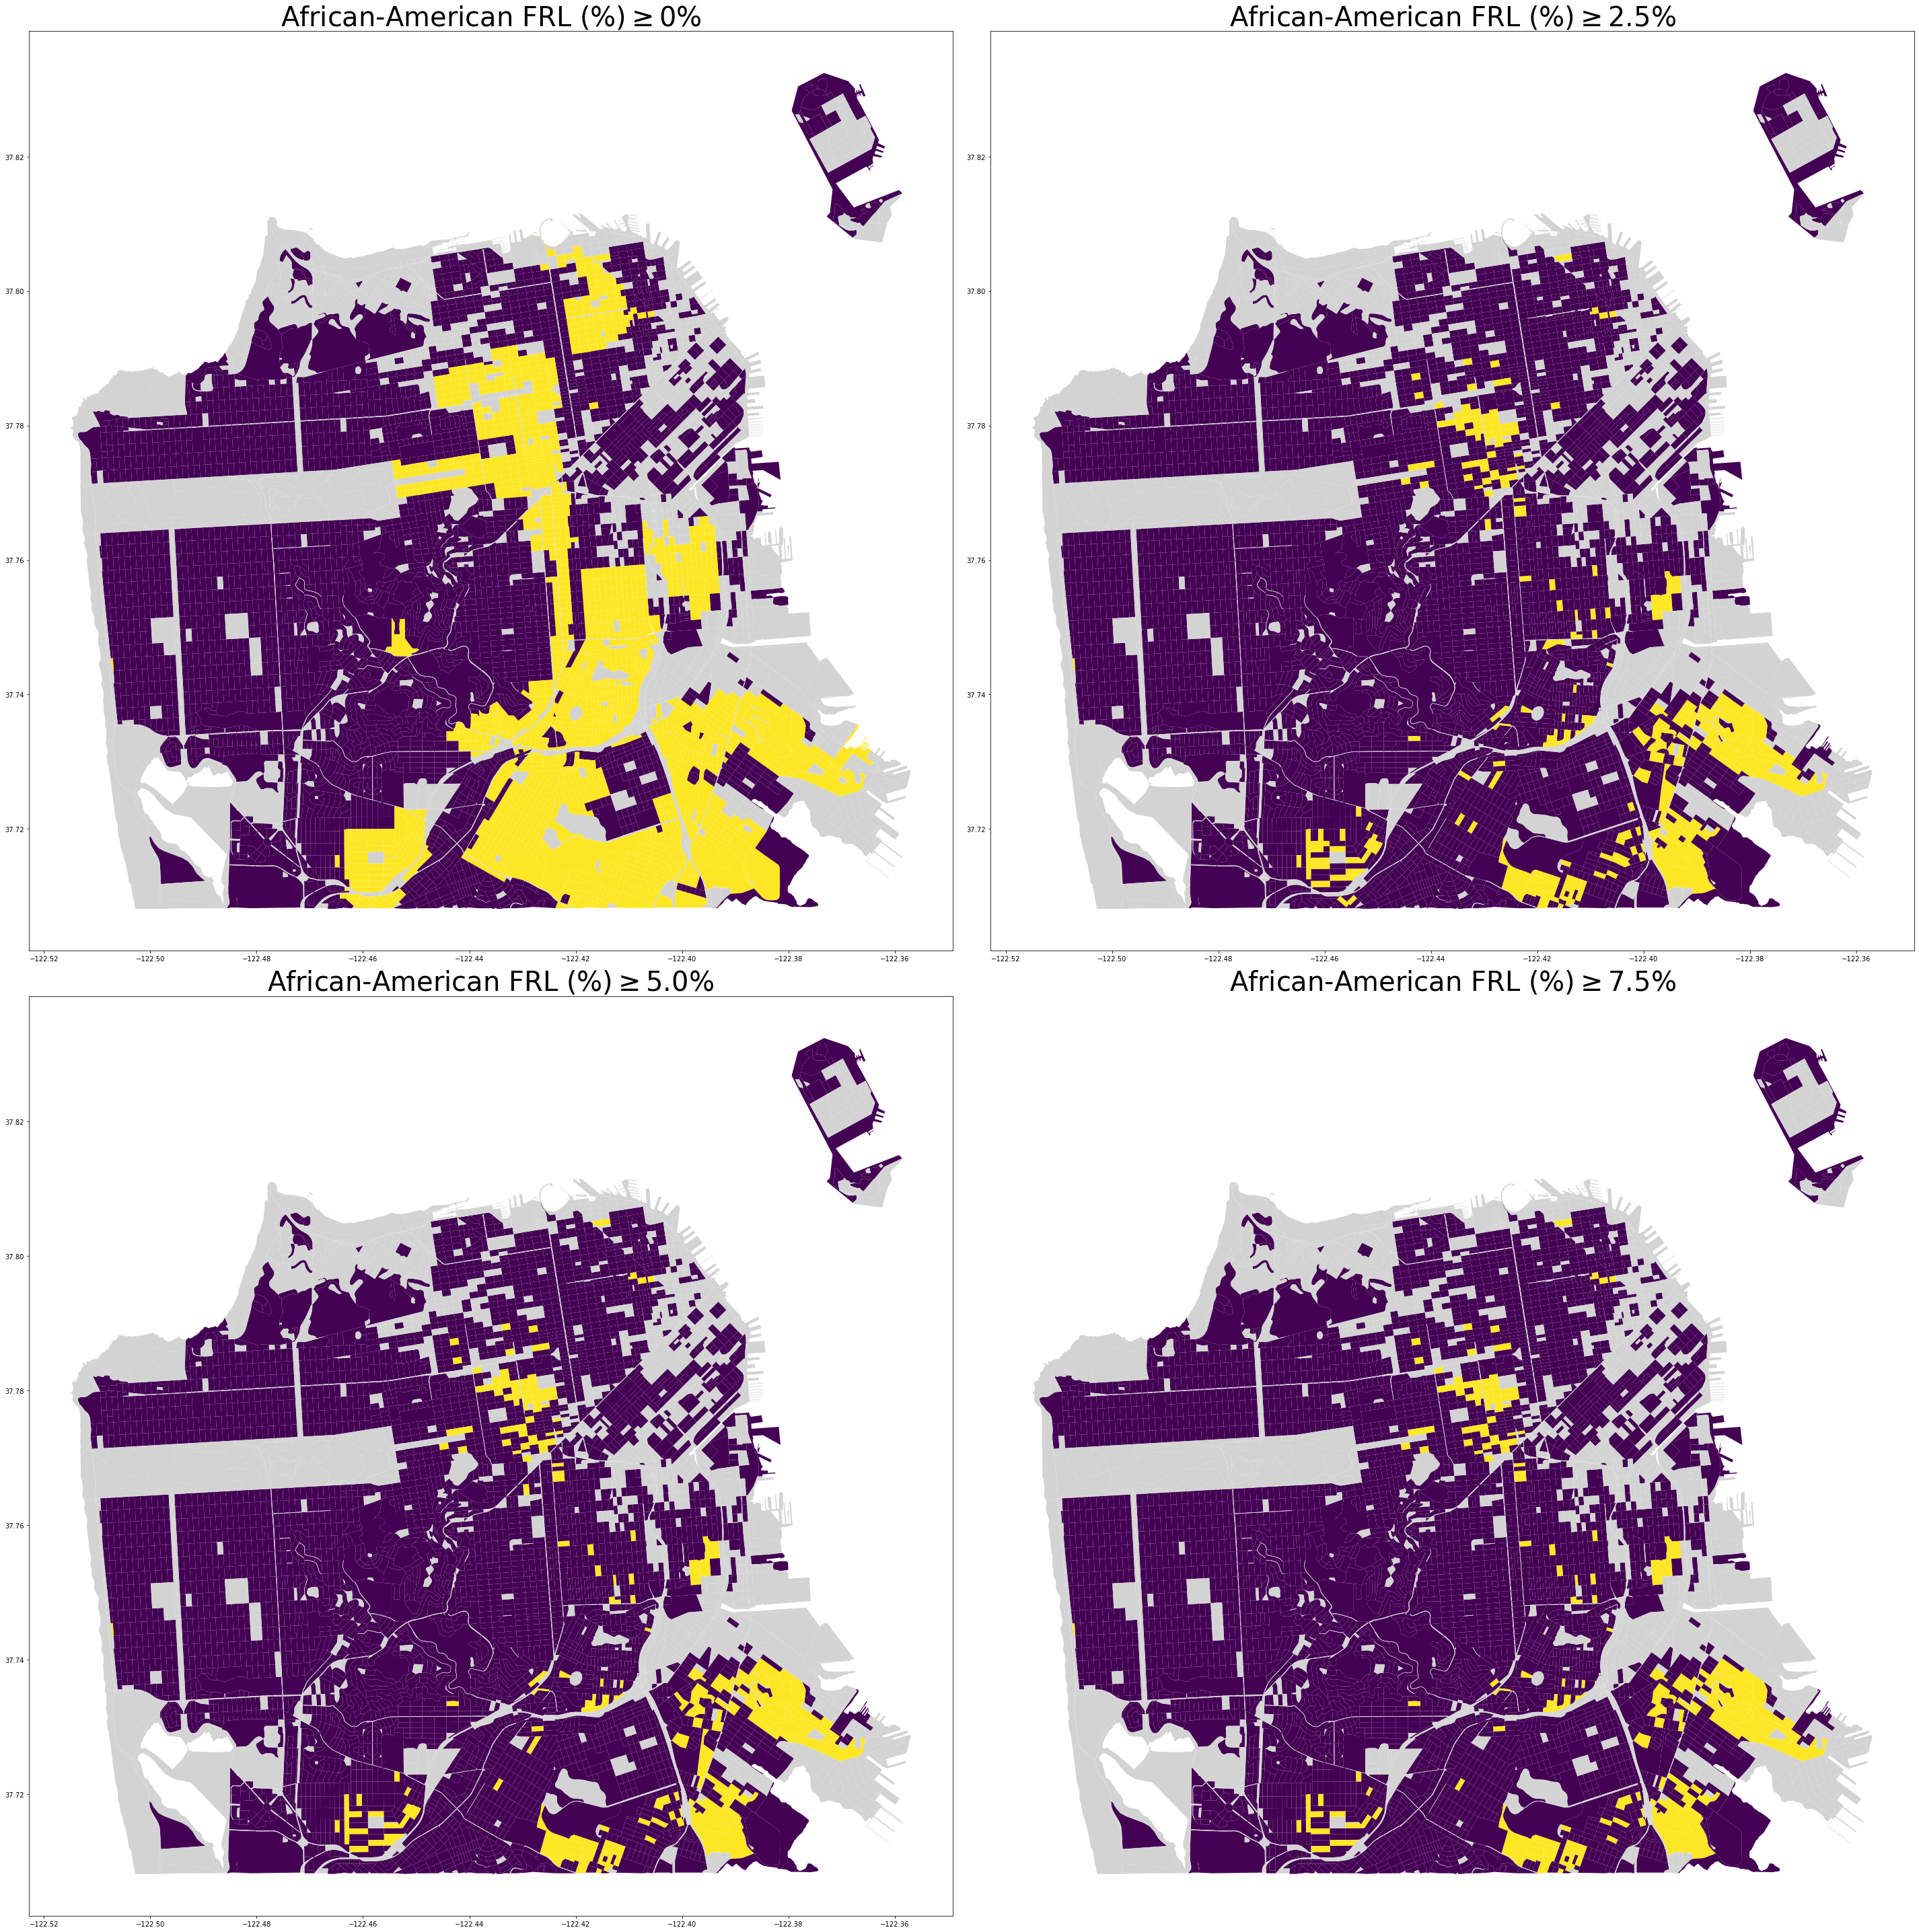

In [11]:
params = [0, 0.025, 0.05, 0.075]
fig, Axes = plt.subplots(figsize=(40,40), nrows=2, ncols=2)
pr, fpr, fnr, imp = [], [], [], []

el = pc.orClassifier(["Housing", "Redline"], binary_var=[0,1])
c = pc.andClassifier(["pctAAFRL"], positive_group="nAAFRL", eligibility_classifier=el, frl_key='kt5')


for beta, ax in zip(params, Axes.flatten()):
    map_df = c.get_tiebreaker_map(beta, "tiebreaker")
    ax = map_df.plot(column="tiebreaker", ax=ax, cmap="viridis",
                     legend=False, missing_kwds={'color': 'lightgrey'})
    ax.set_title("African-American FRL " + "$(\%) \geq $"+str(100*beta)+"%", fontsize=40)
    plt.axis('off')
    pr.append(c.pr(beta))
    fpr.append(c.fpr(beta))
    fnr.append(c.fnr(beta))
    imp.append(1 - c.precision(beta))

fpr = 100*np.reshape(np.array(fpr), (2,2)).round(decimals=2)
fnr = 100*np.reshape(np.array(fnr), (2,2)).round(decimals=2)
pr = 100*np.reshape(np.array(pr), (2,2)).round(decimals=2)
imp = 100*np.reshape(np.array(imp), (2,2)).round(decimals=2)
        
fig.tight_layout()
plt.show()

In [10]:
fpr, fnr, pr, imp

(array([[40., 14.],
        [12., 11.]]),
 array([[18., 19.],
        [21., 22.]]),
 array([[42., 17.],
        [15., 14.]]),
 array([[92., 79.],
        [77., 76.]]))

In [18]:
params = np.linspace(0.,1., 100)

ROC = c.get_roc(params)
ROC['pr'] = [c.pr(alpha) for alpha in params]

In [36]:
c.pr(0.05)

0.14920751029022464